In [1]:
import os, sys
parent_dir = os.path.abspath(os.path.join(os.curdir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
import numpy as np
from src.ik_net import *
from pydrake.all import (
    MultibodyPlant,
    StartMeshcat,
)
from src.utils import RepoDir, BuildEnv, extract_xyzrpy


In [2]:
meshcat = StartMeshcat()
diagram = BuildEnv(meshcat, directives_file = os.path.join(RepoDir(), "models/iiwa_collision.yaml"))
ee_frame = diagram.GetSubsystemByName("plant").GetFrameByName("body")

dataset = IKDataset(diagram, ee_frame)

joint_angles, targets = dataset.create_data(5**7, manifold = [1, 1, 1], matrix=True)

X = np.concatenate([targets, joint_angles[:, 0:1]], axis=1)
y = joint_angles

model = LinearModule(X.shape[1], 7, hidden_layers = [64, 64], dropout_rate=0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = torch.nn.MSELoss()



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# losses = train_model(model, optimizer, loss_fn, X_train, y_train, epochs=1000, batch_size=2048)
# evaluate_model(model, loss_fn, X_test, y_test, dataset)

INFO:drake:Meshcat listening for connections at http://localhost:7001
100%|██████████| 78125/78125 [00:00<00:00, 120442.16it/s]


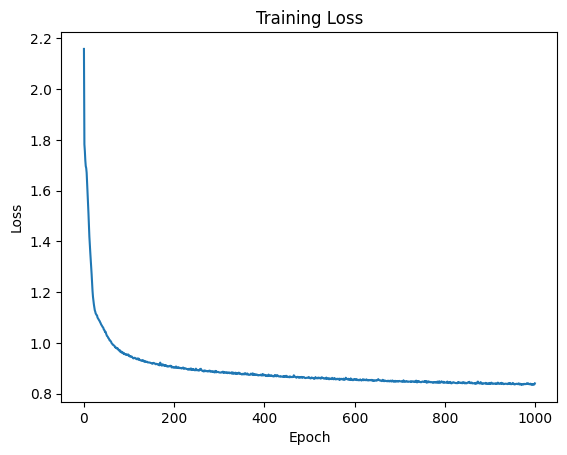

In [11]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
# plt.yscale('log')  # optional: useful if loss decreases a lot
plt.show()

In [9]:
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

optimizer.zero_grad()
print(y_tensor[1])
model(X_tensor[1])

tensor([ 2.6931,  1.6616, -1.9657,  0.9957, -2.2489,  0.6748,  2.9113])


tensor([ 2.6505,  2.0579, -1.6534,  0.7292,  0.1248,  0.7395, -0.0949],
       grad_fn=<ViewBackward0>)

In [13]:
joint_angles[1]

array([ 2.69314317,  1.66155257, -1.96566807,  0.99573811, -2.24894115,
        0.67480338,  2.91133211])

In [3]:
def closure():
    optimizer.zero_grad()
    pred = model(torch.FloatTensor(X_train))
    loss = loss_fn(pred, torch.FloatTensor(y_train))
    loss.backward()
    return loss

optimizer = torch.optim.LBFGS(model.parameters(), lr=1, max_iter=20)

# L-BFGS requires a different training loop
losses = []
for epoch in tqdm(range(100)):  # Fewer epochs needed
    def closure():
        optimizer.zero_grad()
        pred = model(torch.FloatTensor(X_train))
        loss = loss_fn(pred, torch.FloatTensor(y_train))
        loss.backward()
        losses.append(loss.item())
        return loss
    
    optimizer.step(closure)
    
    if epoch % 10 == 0:
        with torch.no_grad():
            pred = model(torch.FloatTensor(X_train))
            loss = loss_fn(pred, torch.FloatTensor(y_train))
            print(f"Epoch {epoch}: Loss = {loss.item():.8f}")

  0%|          | 0/100 [00:00<?, ?it/s]/Users/lunatang/Projects/Urops/Drake/code/ik-net-optimization/drake-env/lib/python3.13/site-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  loss = float(closure())
  1%|          | 1/100 [00:00<00:49,  1.98it/s]

Epoch 0: Loss = 1.76009309


 11%|█         | 11/100 [00:04<00:39,  2.26it/s]

Epoch 10: Loss = 1.35387075


 21%|██        | 21/100 [00:09<00:35,  2.24it/s]

Epoch 20: Loss = 1.11331773


 31%|███       | 31/100 [00:13<00:29,  2.35it/s]

Epoch 30: Loss = 1.01991582


 41%|████      | 41/100 [00:17<00:24,  2.36it/s]

Epoch 40: Loss = 0.95616627


 51%|█████     | 51/100 [00:22<00:22,  2.19it/s]

Epoch 50: Loss = 0.92581314


 61%|██████    | 61/100 [00:26<00:16,  2.39it/s]

Epoch 60: Loss = 0.91019702


 71%|███████   | 71/100 [00:30<00:12,  2.39it/s]

Epoch 70: Loss = 0.89770651


 81%|████████  | 81/100 [00:35<00:08,  2.32it/s]

Epoch 80: Loss = 0.88928169


 91%|█████████ | 91/100 [00:39<00:04,  2.21it/s]

Epoch 90: Loss = 0.88271171


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = torch.nn.MSELoss()

losses = train_model(model, optimizer, loss_fn, X_train, y_train, epochs=1000, batch_size=2048)
evaluate_model(model, loss_fn, X_test, y_test, dataset, matrix=True)

Backwards Loss: 1.837545
Position Loss: 0.195040
Test Loss: 0.901144


In [6]:
model

LinearModule(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=40, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=40, out_features=7, bias=True)
  )
)